# Sample Code

## 基礎建設

In [1]:
import pandas as pd
import gzip, json

def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

## 載入資料

In [2]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz

--2021-12-29 07:17:19--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/All_Beauty.csv
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15499476 (15M) [application/octet-stream]
Saving to: ‘All_Beauty.csv’

All_Beauty.csv      100%[===================>]  14.78M  42.5MB/s    in 0.3s    

2021-12-29 07:17:19 (42.5 MB/s) - ‘All_Beauty.csv’ saved [15499476/15499476]

--2021-12-29 07:17:19--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles2/meta_All_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10329961 (9.9M) [application/octet-stream]
Saving to: ‘meta_All_Beauty.json.gz’

meta_All_Beauty.jso 100%[===================>]   9.85M  35.0MB/s    in 0.3s    

202

In [3]:
metadata = getDF('/content/meta_All_Beauty.json.gz')
ratings = pd.read_csv('/content/All_Beauty.csv', names=['asin', 'reviewerID', 'overall', 'unixReviewTime'], header=None)

In [4]:
metadata.head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes
0,[],,[Loud 'N Clear Personal Sound Amplifier allows...,,Loud 'N Clear&trade; Personal Sound Amplifier,[],,idea village,[],"2,938,573 in Beauty & Personal Care (",[],{'ASIN: ': '6546546450'},All Beauty,,,,6546546450,[],[]
1,[],,[No7 Lift & Luminate Triple Action Serum 50ml ...,,No7 Lift &amp; Luminate Triple Action Serum 50...,"[B01E7LCSL6, B008X5RVME]",,,[],"872,854 in Beauty & Personal Care (",[],"{'Shipping Weight:': '0.3 ounces (', 'ASIN: ':...",All Beauty,"class=""a-bordered a-horizontal-stripes a-spa...",,$44.99,7178680776,[],[]
2,[],,[No7 Stay Perfect Foundation now stays perfect...,,No7 Stay Perfect Foundation Cool Vanilla by No7,[],,No7,[],"956,696 in Beauty & Personal Care (","[B01B8BR0O8, B01B8BR0NO, B014MHXXM8]","{'Shipping Weight:': '3.5 ounces (', 'ASIN: ':...",All Beauty,,,$28.76,7250468162,[],[]
3,[],,[],,Wella Koleston Perfect Hair Colour 44/44 Mediu...,[B0041PBXX8],,,[],"1,870,258 in Beauty & Personal Care (",[],"{' Item Weight: ': '1.76 ounces', 'Sh...",All Beauty,,,,7367905066,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...
4,[],,[Lacto Calamine Skin Balance Daily Nourishing ...,,Lacto Calamine Skin Balance Oil control 120 ml...,[],,Pirmal Healthcare,[],"67,701 in Beauty & Personal Care (","[3254895630, B007VL1D9S, B00EH9A0RI, B0773MBG4...","{'Shipping Weight:': '12 ounces (', 'ASIN: ': ...",All Beauty,,,$12.15,7414204790,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...


In [5]:
ratings.head()

,asin,reviewerID,overall,unixReviewTime
0,0143026860,A1V6B6TNIC10QE,1.0,1424304000
1,0143026860,A2F5GHSXFQ0W6J,4.0,1418860800
2,0143026860,A1572GUYS7DGSR,4.0,1407628800
3,0143026860,A1PSGLFK1NSVO,5.0,1362960000
4,0143026860,A6IKXKZMTKGSC,5.0,1324771200


## 清理資料

In [6]:
metadata_clean = metadata.drop_duplicates('asin')
print(f'Original size: {len(metadata)}, modify: {len(metadata_clean)}')


Original size: 32892, modify: 32488


In [7]:
# title/ rank string clean
print("rank not str Number:",len(metadata_clean["rank"][metadata_clean['rank'].apply(lambda x: type(x)!=str)]))
print("title not str Number:",len(metadata_clean["title"][metadata_clean['title'].apply(lambda x: type(x)!=str)]))

rank not str Number: 402
title not str Number: 0


In [8]:
metadata_clean["rank"] = metadata_clean["rank"].apply(lambda x: x if type(x) == str else "999999999999 in None")
metadata_clean["title"] = metadata_clean["title"].apply(lambda x: x if type(x) == str else "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 資料整理



1. 將metadata重複asin的清除
2. category目前的項目都是空的
2. 若用rank後的資料分類，有404項為無分類



In [51]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [10]:
ratings['DATE'] = pd.to_datetime(ratings['unixReviewTime'], unit='s')

In [11]:
# ranking setting
metadata_clean.loc[:,'ranking'] = metadata_clean.loc[:,'rank'].str.split(expand = True)[0]
metadata_clean.loc[:,'ranking'] = metadata_clean.loc[:,'ranking'].str.replace(',', '')
metadata_clean.loc[:,'ranking'] = pd.to_numeric(metadata_clean.loc[:,'ranking'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [12]:
# category check
number = len(metadata_clean['category'][metadata_clean['category'].apply(lambda x: len(x)) > 0])
print(f'There are {number} catagory having data.')

There are 0 catagory having data.


In [22]:
metadata_clean["sub_category"] = metadata_clean["rank"].str.split("in ").str[1].replace(r"\(","", regex=True).replace(r"\&amp;","&", regex=True)
metadata_clean["sub_category"].value_counts().rename_axis('name').reset_index(name='counts')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,name,counts
0,Beauty & Personal Care,32015
1,None,402
2,Grocery & Gourmet Food,37
3,Health & Household,21
4,Sports & Outdoors,3
5,Toys & Games,3
6,Baby,2
7,"Clothing, Shoes & Jewelry",2
8,Automotive,1
9,Home & Kitchen,1


### 對sub_category = None 針對性分析

In [14]:
metadata_clean[metadata_clean["sub_category"]=="None"].head()

,category,tech1,description,fit,title,also_buy,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin,imageURL,imageURLHighRes,ranking,sub_category
36,[],,[<P><STRONG>Helps Reduce Appearance Of Hair Gr...,,Nair Hair Remover 4 Minute Lotion with Aloe &a...,[],,nair,[],999999999999 in None,[],"{'Shipping Weight:': '6.4 ounces', 'ASIN: ': '...",All Beauty,,,,B000052WYR,[],[],999999999999,None
38,[],,[Scope Original Mint Rinse kills bad breath ge...,,Scope Original Mint Mouthwash 50.7 Fl Oz,"[B009LNU6ME, B00L1I1VYY, B00J5K0QEQ, B0035U184...",,Unknown,[],999999999999 in None,"[B009LNU6ME, B007CRIFSS, B074KHNR82, B01FVAYP8...",{' Product Dimensions: ': '5.1 x 3.7 ...,All Beauty,,,,B000052YD8,[],[],999999999999,None
43,[],,[Using this is like chumming the air for prett...,,Old Spice High Endurance Anti-Perspirant &amp;...,[],,Old Spice,[],999999999999 in None,"[B006Y3JDH8, B01I9THZKQ, B07CPFGVM3, B0014CU2U...",{' Product Dimensions: ': '5 x 2.1 x ...,All Beauty,,,$5.21,B00005308B,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,999999999999,None
46,[],,[Naturally comfort your skin with this St. Ive...,,St. Ives Advanced Therapy Lotion for Extra Dry...,[],,St. Ives,[],999999999999 in None,[],{' Product Dimensions: ': '8.7 x 3.4 ...,All Beauty,,,,B0000530ND,[],[],999999999999,None
54,[],,"[, <strong>Platinum Protection is the best dry...",,Secret Platinum Protection Antiperspirant &amp...,[],,Secret,[],999999999999 in None,[],"{'Shipping Weight:': '4.8 ounces', 'Domestic S...",All Beauty,,,,B00005354G,[https://images-na.ssl-images-amazon.com/image...,[https://images-na.ssl-images-amazon.com/image...,999999999999,None


In [36]:
def historyCounts(start, end, biastime):
  current = start
  output = []
  index = {name: i for i, name in enumerate(np.unique(metadata_clean["sub_category"]))}
  while current < end:
    tmp = [0]*len(index)
    currentTime = current.strftime("%Y-%m-%d")
    nextTime = (current+biastime).strftime("%Y-%m-%d")
    print(f'{currentTime} -> {nextTime}')
    tmpdata = ratings[(ratings['DATE'] >= currentTime) & (ratings['DATE'] < nextTime)]
    for item, row in tmpdata.iterrows():
      asin = row['asin']
      sub_category = metadata_clean[metadata_clean["asin"]==asin]
      if len(sub_category) > 0:
        sub_category = sub_category["sub_category"].iloc[0]
        tmp[index[sub_category]] += 1
    output.append(tmp)
    current = current + biastime
  return output

output = historyCounts(datetime(2017,1,1), datetime(2018,10,1), relativedelta(months=1))

'''
output =
[[2, 0, 8496, 0, 10, 7, 0, 97, 5, 0, 0],
 [0, 0, 6453, 0, 6, 3, 0, 75, 0, 0, 0],
 [0, 0, 7401, 2, 6, 5, 0, 44, 0, 0, 1],
 [1, 0, 5979, 0, 6, 3, 0, 54, 1, 0, 1],
 [1, 0, 5565, 0, 4, 4, 0, 58, 0, 1, 0],
 [0, 1, 5192, 0, 6, 1, 0, 59, 0, 0, 0],
 [1, 0, 5330, 0, 4, 2, 0, 29, 0, 1, 0],
 [0, 0, 5892, 1, 3, 0, 0, 46, 0, 0, 1],
 [0, 0, 5865, 1, 5, 0, 1, 44, 0, 0, 0],
 [0, 0, 4587, 0, 2, 1, 0, 50, 0, 1, 0],
 [1, 0, 4142, 0, 8, 0, 0, 34, 0, 0, 1],
 [1, 0, 3893, 0, 2, 0, 0, 68, 1, 0, 0],
 [0, 0, 4766, 0, 3, 0, 0, 66, 0, 0, 0],
 [0, 0, 4389, 0, 4, 5, 0, 45, 0, 1, 2],
 [0, 0, 4869, 0, 5, 12, 0, 49, 0, 0, 0],
 [1, 0, 4542, 0, 9, 12, 0, 49, 0, 1, 0],
 [0, 0, 3749, 1, 5, 5, 0, 29, 0, 0, 1],
 [0, 0, 2936, 0, 7, 6, 0, 25, 1, 1, 0],
 [1, 0, 2347, 0, 3, 12, 0, 22, 1, 1, 0],
 [0, 0, 1644, 0, 6, 1, 0, 11, 0, 0, 0],
 [2, 0, 584, 0, 1, 1, 0, 2, 0, 0, 0]]
'''

2017-01-01 -> 2017-02-01
2017-02-01 -> 2017-03-01
2017-03-01 -> 2017-04-01
2017-04-01 -> 2017-05-01
2017-05-01 -> 2017-06-01
2017-06-01 -> 2017-07-01
2017-07-01 -> 2017-08-01
2017-08-01 -> 2017-09-01
2017-09-01 -> 2017-10-01
2017-10-01 -> 2017-11-01
2017-11-01 -> 2017-12-01
2017-12-01 -> 2018-01-01
2018-01-01 -> 2018-02-01
2018-02-01 -> 2018-03-01
2018-03-01 -> 2018-04-01
2018-04-01 -> 2018-05-01
2018-05-01 -> 2018-06-01
2018-06-01 -> 2018-07-01
2018-07-01 -> 2018-08-01
2018-08-01 -> 2018-09-01
2018-09-01 -> 2018-10-01


In [54]:
def historyTimestep(start, end, biastime):
  timestep = []
  current = start
  while current < end:
    currentTime = current.strftime("%Y-%m-%d")
    timestep.append(currentTime)
    current = current + biastime
  return timestep

sub_category_Counts = pd.DataFrame(output, columns=np.unique(metadata_clean["sub_category"]))
sub_category_Counts.index = historyTimestep(datetime(2017,1,1), datetime(2018,10,1), relativedelta(months=1))
sub_category_Counts

,Automotive,Baby,Beauty & Personal Care,"Clothing, Shoes & Jewelry",Grocery & Gourmet Food,Health & Household,Home & Kitchen,None,Sports & Outdoors,Tools & Home Improvement,Toys & Games
2017-01-01,2,0,8496,0,10,7,0,97,5,0,0
2017-02-01,0,0,6453,0,6,3,0,75,0,0,0
2017-03-01,0,0,7401,2,6,5,0,44,0,0,1
2017-04-01,1,0,5979,0,6,3,0,54,1,0,1
2017-05-01,1,0,5565,0,4,4,0,58,0,1,0
2017-06-01,0,1,5192,0,6,1,0,59,0,0,0
2017-07-01,1,0,5330,0,4,2,0,29,0,1,0
2017-08-01,0,0,5892,1,3,0,0,46,0,0,1
2017-09-01,0,0,5865,1,5,0,1,44,0,0,0
2017-10-01,0,0,4587,0,2,1,0,50,0,1,0


#############===
Automotive 


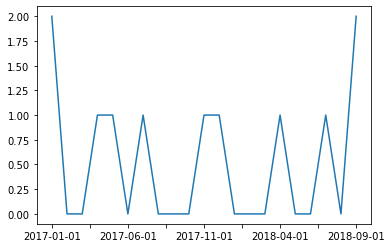


#############===
Baby 


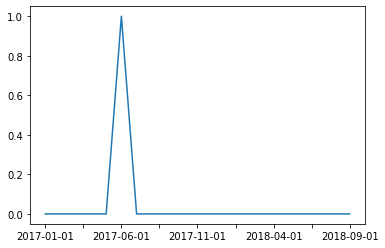


#############===
Beauty & Personal Care 


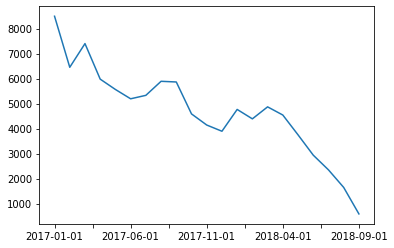


#############===
Clothing, Shoes & Jewelry 


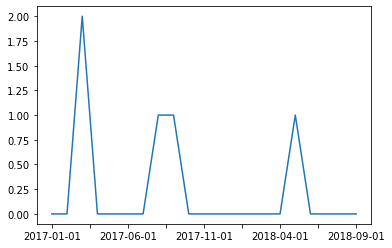


#############===
Grocery & Gourmet Food 


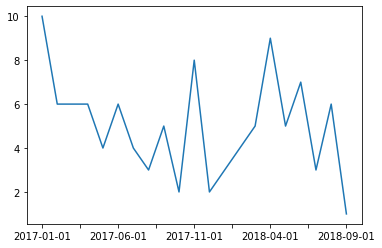


#############===
Health & Household 


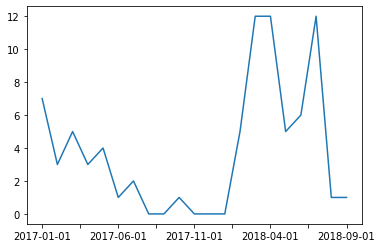


#############===
Home & Kitchen 


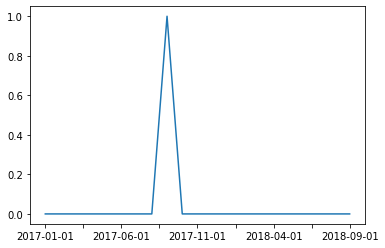


#############===
None


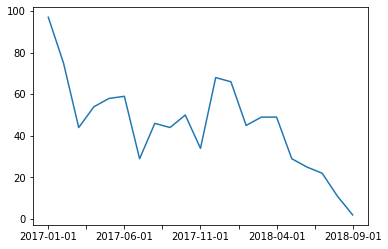


#############===
Sports & Outdoors 


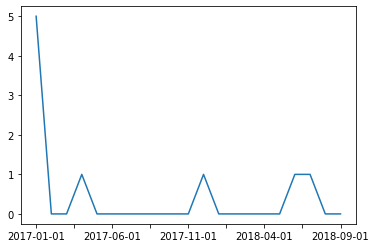


#############===
Tools & Home Improvement 


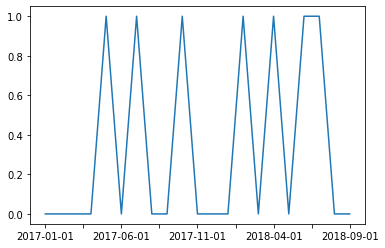


#############===
Toys & Games 


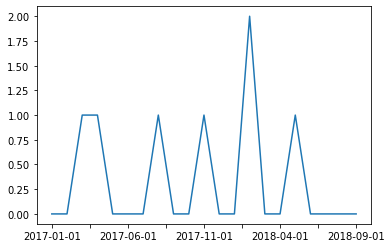

In [57]:
for column in sub_category_Counts.columns:
  print("#############===")
  print(column)
  sub_category_Counts[column].plot()
  plt.show()
  print()

## 資料切分

In [ ]:
ratings_trainings = ratings[
    (ratings['DATE'] < '2018-09-01')
]
ratings_testings = ratings[
    (ratings['DATE'] >= '2018-09-01') & 
    (ratings['DATE'] <= '2018-09-30')
]
ratings_testings_by_user = ratings_testings.groupby('reviewerID').agg(list).reset_index()[['reviewerID', 'asin']].to_dict('records')
ratings_testings_by_user = { rating['reviewerID']: rating['asin'] for rating in ratings_testings_by_user }
users = list(ratings_testings_by_user.keys())

## 標題（Title）TF-IDF分析

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 計算商品用標題所表示的 tfidf 矩陣
df = metadata.drop_duplicates('title')
tf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tf.fit_transform(df['title'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(tfidf_matrix)

In [ ]:
mapping = pd.Series(df.index,index = df['title'])
def recommend_item(item_input, k=2):
    try:
        item_index = mapping[item_input]
        similarity_score = list(enumerate(similarity_matrix[item_index]))
        similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
        similarity_score = similarity_score[:k]
        item_indices = [i[0] for i in similarity_score]
        return (df['asin'].iloc[item_indices].tolist())
    except:
        return []

In [ ]:
def recommend_items(items, k):
    res = []
    for d in items:
        res.extend(recommend_item(d, k))
    return res

In [ ]:
recommend_items(items=["Loud 'N Clear&trade; Personal Sound Amplifier"], k=10)

['6546546450',
 'B002W3172S',
 'B001FT5DMU',
 'B008L2UR66',
 'B00WUUW18W',
 'B00QUAL0BW',
 'B01G689TOC',
 'B00DG53QSE',
 'B00632SBHS',
 'B00C69IXIY']

In [ ]:
print(len(metadata))

32892


In [ ]:
for asin in recommend_items(items=["Loud 'N Clear&trade; Personal Sound Amplifier"], k=10):
  print(asin," : ",metadata[metadata["asin"]==asin]["title"].values)

6546546450  :  ["Loud 'N Clear&trade; Personal Sound Amplifier"]
B002W3172S  :  ['Super Loud Air Horn (2 oz)']
B001FT5DMU  :  ['Juice Organics Lip Amplifier - 0.5 oz.']
B008L2UR66  :  ['Dove Mousse Nourishing Amplifier 7 (Pack of 3)']
B00WUUW18W  :  ["Bare Escentuals bareMinerals 'Loud &amp; Clear' Lip Sheer (1.9 g) - Unboxed - Magenta Vibe"]
B00QUAL0BW  :  ['bareMinerals Loud &amp; Clear Lip Duo - Amped Pink/Tangerine Trance']
B01G689TOC  :  ['Bare Minerals Loud and Clear Lip Sheer Pink Pulse 0.07oz in retail box']
B00DG53QSE  :  ['In Line Amplifier Tone Control 40Db']
B00632SBHS  :  ['Prive Shining Weightless Amplifier 6.8 oz (Pack of 2)']
B00C69IXIY  :  ['Safe and Sound Lockable Safety Pill Cutter']


## 產生推薦

In [ ]:
def recommender(training_data, users=[], k=10):
    '''
    * training_data: dataframe 輸入的訓練資料集（2018-09-01 以前資料）
    * users: [] 需要被推薦的使用者
    * k: int 每個使用者需要推薦的商品數
    * recommendations: dict
      {
          使用者一： [推薦商品一, 推薦商品二, ...],
          使用者二： [...], ...
      }
    '''
    recommendations = {}
    '''
    Your Code
    '''
    return recommendations


ratings_by_user = recommender(ratings_trainings, users)
ratings_by_user

{}

## 結果評估

In [ ]:
def evaluate(ratings_testings_by_user={}, ratings_by_user={}, method=None):
    '''
    * ratings_testings_by_user: dict 真實被購買的商品資料（2018-09-01 以後資料）
    * ratings_by_user: dict 利用訓練資料學習的推薦商品
    * method: str
    * score: float
    '''
    total = 0
    for d in ratings_testings_by_user:
        if d in ratings_by_user:
            total += len(set(ratings_by_user[d]) & set(ratings_testings_by_user[d]))

    score = total / len(ratings_testings)
    return score

evaluate(ratings_testings_by_user, ratings_by_user)

0.0